# Import Libraries

In [5]:
import os
import time
import random
import joblib
from collections import Counter
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
from skimage import feature as ft
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb


import warnings
warnings.filterwarnings("ignore")

In [6]:
data_dir = "/kaggle/input/neu-plantseedlingsclassification12/Nonsegmented_pack - k/"

class_names = os.listdir(data_dir + "train/")
classes_dict = dict()

for i, name in enumerate(class_names):
    classes_dict[name] = i
classes_dict

{'Scentless Mayweed': 0,
 'Common wheat': 1,
 'Charlock': 2,
 'Black-grass': 3,
 'Sugar beet': 4,
 'Loose Silky-bent': 5,
 'Maize': 6,
 'Cleavers': 7,
 'Common Chickweed': 8,
 'Fat Hen': 9,
 'Small-flowered Cranesbill': 10,
 'Shepherds Purse': 11}

# Image Processing

## equalize(): Histogram Equalization (直方图均衡)

In [7]:

def equalize(img):
    b, g, r = cv2.split(img)   
    b = cv2.equalizeHist(b)
    g = cv2.equalizeHist(g)    
    r = cv2.equalizeHist(r)
    
    img_equalized = cv2.merge((b, g, r))
    
    return img_equalized

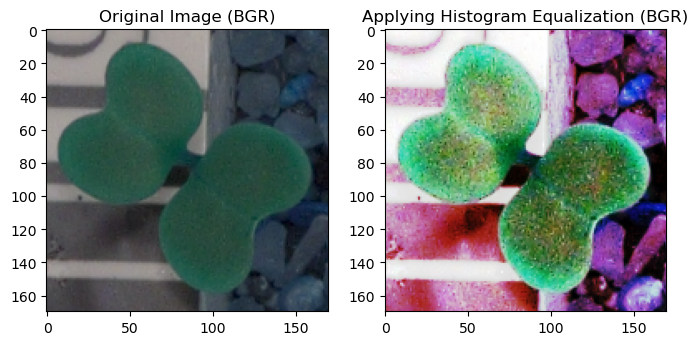

In [8]:
## TEST

img_bgr_try = cv2.imread(data_dir + "train/Charlock/aahijusizs.png")
img_equalized = equalize(img_bgr_try)

fig  = plt.figure(figsize=(8, 16))
ax1 = plt.subplot(121)
ax1.imshow(img_bgr_try)
ax1.set_title("Original Image (BGR)")
ax2 = plt.subplot(122)
ax2.imshow(img_equalized)
ax2.set_title("Applying Histogram Equalization (BGR)")
plt.show()

## extract_seedling(): Extracting Seedling (green parts)

In [9]:
def extract_seedling(img):
    """Parameter `img` is read by cv2.imread(), so it is in BGR mode"""
    
    # Green color range
    green_lower = np.array([35, 43, 46], dtype="uint8")   # Lower bound
    green_upper = np.array([90, 255, 255], dtype="uint8") # Upper bound
    
    # Gaussian filtering
    img_gaussed = cv2.GaussianBlur(img, (3, 3), 0)
    img_gaussed = cv2.cvtColor(img_gaussed, cv2.COLOR_BGR2HSV)
    
    # Binarization to create mask
    mask = cv2.inRange(img_gaussed, green_lower, green_upper)
    
    img_extracted = cv2.bitwise_and(img, img, mask=mask)
    
    return img_extracted

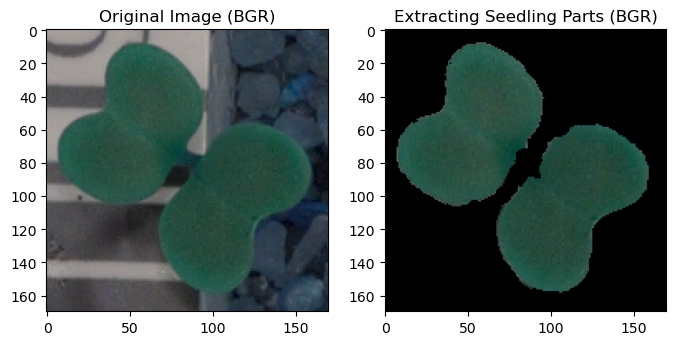

In [10]:
## TEST

img_bgr_try = cv2.imread(data_dir + "train/Charlock/aahijusizs.png")
img_extracted = extract_seedling(img_bgr_try)

fig  = plt.figure(figsize=(8, 16))
ax1 = plt.subplot(121)
ax1.imshow(img_bgr_try)
ax1.set_title("Original Image (BGR)")
ax2 = plt.subplot(122)
ax2.imshow(img_extracted)
ax2.set_title("Extracting Seedling Parts (BGR)")
plt.show()

## preprocessing_imgs()

This function is almost the same as `process()` in the referenced notebook, but I comment out the codes that to store the preprocessed images.

In [11]:
def preprocessing_imgs(file_dir):
    """Preprocess train image by applying equalize() and then extract_seedling().
       Store the preprocessed images in train_preprocessed folder and get their class labels."""
    
    images_list = []
    labels_list = []
    
    classes = os.listdir(file_dir)
    # print(classes)
    
    for cls in classes:
        img_names = os.listdir(file_dir + cls)
        # cls_folder = train_preprocessed_dir + cls
        # if not os.path.exists(cls_folder):
        #     os.makedirs(cls_folder)        # Create class folder if it does not exist
            
        for img_name in img_names:
            img_bgr = cv2.imread(file_dir + cls + '/' + img_name)
            img_equalized = equalize(img_bgr)
            img_seedling = extract_seedling(img_equalized)
            # cv2.imwrite(cls_folder + '/' + img_name, img_seedling)
            
            images_list.append(img_seedling)
            labels_list.append(classes_dict[cls])
    img_text_list=os.listdir("/kaggle/input/neu-plantseedlingsclassification12/Nonsegmented_pack - k/test/")
    for img_name in img_text_list:
        img_bgr = cv2.imread("/kaggle/input/neu-plantseedlingsclassification12/Nonsegmented_pack - k/test/" + img_name)
        img_equalized = equalize(img_bgr)
        img_seedling = extract_seedling(img_equalized)
        images_list.append(img_seedling)
    return images_list, labels_list

In [12]:
images_list, labels_list = preprocessing_imgs(data_dir + "train/")
num_per_class = Counter(labels_list)


In [13]:
all_label = np.array(labels_list)

print(f'图像数量: {len(images_list)}')                 # 4750
print(f'第一张图片的shape: {images_list[0].shape}')    # (w, h, 3)
print(f'label数量: {all_label.shape[0]}')              # 4750

图像数量: 5544
第一张图片的shape: (509, 509, 3)
label数量: 4440


## resize_imgs()

In [14]:
def resize_imgs(images_list):
    """Resize images into the shape as (128, 128, 3) to ensure that they have the same shape."""
    
    imgs_list = []
    for image in images_list:
        image = cv2.resize(image, (128, 128)) 
        imgs_list.append(image)
    return imgs_list

<br>

# Features Extraction and Processing

<br>

## Helper Functions

### fill_missing()

In [15]:
# 填充缺失值
def fill_missing(feature):
    feature_df = pd.DataFrame(feature)      # 转为 DataFrame 格式，才能使用 fillna 函数
    feature_df_fill = feature_df.fillna(0)  # 将缺失值部分填充0
    
    return np.array(feature_df_fill)        # 返回array格式

<br>

### normalize()

In [16]:
# 标准化
def normalize(feature):
    scaler = StandardScaler()
    scaler.fit(feature)
    feature_normal = scaler.transform(feature)
    
    return feature_normal

<br>

### dimensionalityReduction()


由于提取出的 HOG，LBP 的特征维数很大，如果直接使用全部的特征矩阵作为训练集特征，训练速度很慢，且他们作为特征的占比过多，会影响到训练效果，导致准确率不高，因此需要使用主成分分析（PCA）对特征进行降维。

其中 `estimator.explained_variance_ratio_` 表示降维后每个维度能代表原先特征的占比，遍历并对其累加输出，方便确定一个好的降维维度数，使其维度不太多且能代表原先特征的较高占比，尽量减少降维所造成的特征损失。


In [17]:
# Use PCA(Principal Component Analysis) to reduce dimensionality
def dimensionalityReduction(feature, n=100, is_whiten=False, is_show=True):
    estimator = PCA(n_components=n, whiten=is_whiten)
    pca_feature = estimator.fit_transform(feature)
    
    sum = 0
    for ratio in estimator.explained_variance_ratio_:
        sum += ratio
        if is_show:
            print(sum)
    
    print('降维后特征矩阵shape为:', pca_feature.shape)
    print('主成分比例为:', sum)
    
    return pca_feature

<br>

### save_feature()

In [18]:
print(os.getcwd())

os.makedirs("./save_features", exist_ok=True)

/kaggle/working


In [19]:
feature_dir = "./save_features/"

# 将提取出的特征数组（二维）保存到npy文件中
def save_feature(feature, fileName):
    np.save(feature_dir + fileName + '.npy', feature, allow_pickle=True)
    
    print(fileName + '.npy', '文件已生成！')

<br>

### read_feature()

In [20]:
feature_dir = "./save_features/"

# 读取之前保存好的 feature 文件，返回特征矩阵（二维数组）
def read_feature(fileName):
    feature = np.load(feature_dir + fileName + '.npy', allow_pickle=True)
    print('已读取', fileName, '文件！\t shape = ', feature.shape)

    return feature

<br>
<br>

## Features Extraction

### SIFT + BOW

#### SIFT

In [21]:
def sift_feature(images_list):
    """Extract SIFT feature of the image"""
    
    feature_sift_list = []  # SIFT特征向量列表
    
    # sift = cv2.xfeatures2d.SIFT_create()   # old-version cv2
    sift = cv2.SIFT_create()
    
    for i in tqdm(range(len(images_list))):
        image = cv2.cvtColor(images_list[i], cv2.COLOR_BGR2GRAY)
        
        # Obtain SIFT feature，kp is keypoints，des is descriptors (feature vectors)
        kp, des = sift.detectAndCompute(image, None)
        feature_sift_list.append(des)
        
    return feature_sift_list

kp[0] = <KeyPoint 0x7abd1818cc30>
len(kp) = 39
des.shape = (39, 128)


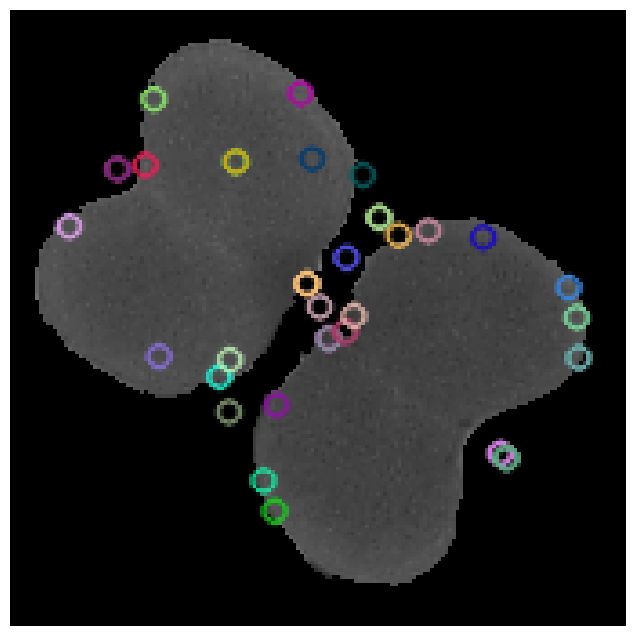

CPU times: user 213 ms, sys: 92.8 ms, total: 306 ms
Wall time: 150 ms


In [22]:
%%time

## TEST SIFT
sift = cv2.SIFT_create()

img_extracted_gray = cv2.cvtColor(img_extracted, cv2.COLOR_BGR2GRAY)

kp = sift.detect(img_extracted_gray, None)   #  找到关键点

# 绘制关键点 
img_kp_gray = cv2.drawKeypoints(img_extracted_gray, kp, img_extracted_gray)

# 计算关键点对应的sift特征向量
# kp为关键点列表，des为numpy的数组，为 (关键点数目,128)
kp, des = sift.compute(img_kp_gray, kp)

print('kp[0] =', kp[0])
print('len(kp) =', len(kp))
print('des.shape =', des.shape)

plt.figure(figsize=(8,8))
plt.imshow(img_kp_gray)
plt.axis('off')
plt.show()

In [23]:
%%time

# 获取 SIFT 特征列表
feature_sift_list = sift_feature(images_list)

 10%|▉         | 540/5544 [00:15<02:24, 34.64it/s]


KeyboardInterrupt: 

In [24]:
print(len(feature_sift_list))     # 4750
print(feature_sift_list[0])
print()

# 以下3个输出为sift特征的 shape, 为 (关键点数量, 128)
print(feature_sift_list[0].shape)      # (?, 128)
print(feature_sift_list[1].shape)      # (?, 128)
print(feature_sift_list[100].shape)    # (?, 128)

NameError: name 'feature_sift_list' is not defined

<br>

#### BOW

In [ ]:
## Initialize BOW Trainer

def bow_init(feature_sift_list):
    """Initialize BOW trainer"""
    
    ## 创建BOW训练器，指定 k-means 参数 k 把处理好的特征数据全部合并，利用聚类把特征词分为若干类，
    ## 此若干类的数目由自己设定，每一类相当于一个视觉词汇
    bow_kmeans_trainer = cv2.BOWKMeansTrainer(100)    # 100 个词汇
    
    for feature_sift in feature_sift_list:
        bow_kmeans_trainer.add(feature_sift)
    
    # 进行k-means聚类，返回词汇字典 也就是聚类中心
    voc = bow_kmeans_trainer.cluster()
    
    # 输出词汇字典
    print("In bow_init(), print variable `voc`: ")
    print(type(voc), voc.shape)    # <class 'numpy.ndarray'> (100, 128)
    print(voc)
    print()
    
    # FLANN 匹配  
    # algorithm 用来指定匹配所使用的算法，可以选择的有 LinearIndex、KTreeIndex、KMeansIndex、CompositeIndex 和 AutotuneIndex
    # 这里选择的是 KTreeIndex (使用 kd树 实现最近邻搜索)
    flann_params = dict(algorithm=1, tree=5)           # define parameters for cv2.FlannBasedMatcher()
    flann = cv2.FlannBasedMatcher(flann_params,{})
    
    print(flann)
    
    #初始化 bow 提取器(设置词汇字典),用于提取每一张图像的BOW特征描述
    # sift = cv2.xfeatures2d.SIFT_create()   # old-version cv2
    sift = cv2.SIFT_create()
    bow_img_descriptor_extractor = cv2.BOWImgDescriptorExtractor(sift, flann)        
    bow_img_descriptor_extractor.setVocabulary(voc)
    
    print(bow_img_descriptor_extractor)
    
    return bow_img_descriptor_extractor

In [ ]:
## Extract BOW Features
def bow_feature(bow_img_descriptor_extractor, images_list):
    # 分别对每个图片提取BOW特征，获得BOW特征列表
    feature_bow_list = []
    
    # sift = cv2.xfeatures2d.SIFT_create()   # old-version cv2
    sift = cv2.SIFT_create()
    for i in tqdm(range(len(images_list))):
        image = cv2.cvtColor(images_list[i], cv2.COLOR_BGR2GRAY)
        feature_bow = bow_img_descriptor_extractor.compute(image,sift.detect(image))
        feature_bow_list.append(feature_bow)
        
    return np.array(feature_bow_list)[:,0,:]

<br>

In [ ]:
%%time
## 获取 SIFT + BOW 特征

# 从图像中提取并保存在npy文件中
bow_extractor = bow_init(feature_sift_list)
all_feature_bow = bow_feature(bow_extractor, images_list)  # shape = (4750, 100)
save_feature(all_feature_bow, 'all_feature_bow')

<br>

### HOG

In [ ]:
# 所有图片 resize 成(128,128)，保证每个图像提取出的 HOG，LBP 特征数量一致
# 提取 HOG，LBP 特征前调用
images_list = resize_imgs(images_list)

In [25]:
# 提取 HOG 特征
def hog_feature(image_list):
    feature_hog_list = []
    for i in tqdm(range(len(image_list))):  # ft is short for skimage.feature
        feature_hog = ft.hog(image_list[i], 
                             orientations=16, 
                             pixels_per_cell=(32, 32), 
                             cells_per_block=(3, 3), 
                             feature_vector=True, 
                             multichannel=True)
        feature_hog_list.append(feature_hog)
    
    return np.array(feature_hog_list)

In [ ]:
# %%time

# ## 获取 HOG 特征
# ## 从图像中提取并保存在 csv 文件中
# all_feature_hog = hog_feature(images_list)

# print('all_feature_hog.shape =', all_feature_hog.shape)
# save_feature(all_feature_hog, 'all_feature_hog')

1296


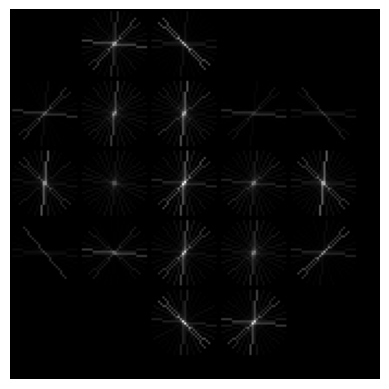

In [26]:
# TEST HOG
feature_hog = ft.hog(img_extracted, 
                     orientations=16, 
                     pixels_per_cell=(32, 32), 
                     cells_per_block=(3, 3), 
                     feature_vector=True,
                     multichannel=True, 
                     visualize=True)
print(feature_hog[0].shape[0])
plt.imshow(feature_hog[1], cmap=plt.cm.gray)
plt.axis('off')
plt.show()

<br>

### LBP

In [28]:
# 提取 LBP 特征
def lbp_feature(images_list):
    feature_lbp_list = []
    for j in tqdm(range(len(images_list))):
        feature_lbp = []
        image = images_list[j]
        for i in range(3):
            feature_lbp.append(ft.local_binary_pattern(np.array(image[:,:,i]), 64, 64, 'var'))
        feature_lbp_list.append(feature_lbp)
    return np.array(feature_lbp_list)

In [27]:
%%time

## 获取 LBP 特征
all_feature_lbp = lbp_feature(images_list)    # shape = (4750, 3, 128, 128)
print(np.array(all_feature_lbp).shape)        # (4750, 3, 128, 128)



## 将四维转为二维
all_feature_lbp = all_feature_lbp.reshape(all_feature_lbp.shape[0], 
                                          all_feature_lbp.shape[1] * all_feature_lbp.shape[2] * all_feature_lbp.shape[3])

print('all_feature_lbp.shape =', all_feature_lbp.shape)  # (4750, 49152)

NameError: name 'lbp_feature' is not defined

In [29]:
# TEST LBP
feature_lbp = []
for i in range(3):
    feature_lbp.append(ft.local_binary_pattern(img_extracted[:,:,i], 64, 64, 'var'))
print(feature_lbp)    # list of ndarray
print()

feature_lbp_array = np.array(feature_lbp)
print(feature_lbp_array.shape)

# 挑选出非 nan 值
feature_lbp_array[np.logical_not(np.isnan(feature_lbp_array))]

[array([[278.50384691, 282.90452195, 274.80621115, ...,          nan,
                 nan,          nan],
       [274.4562018 , 283.16683774, 276.84404801, ...,          nan,
                 nan,          nan],
       [282.22285735, 292.07114482, 319.61671987, ...,          nan,
                 nan,          nan],
       ...,
       [         nan,          nan,          nan, ..., 145.32869179,
        130.01670456, 154.27290973],
       [         nan,          nan,          nan, ..., 135.31306533,
        143.10351307, 175.49121016],
       [         nan,          nan,          nan, ..., 130.62466658,
        144.97686644, 174.71747975]]), array([[1283.49866687, 1282.0703602 , 1249.51501948, ...,           nan,
                  nan,           nan],
       [1267.99469371, 1275.73247083, 1248.87110895, ...,           nan,
                  nan,           nan],
       [1273.80206805, 1276.51586222, 1301.64252821, ...,           nan,
                  nan,           nan],
       ...,
 

array([278.50384691, 282.90452195, 274.80621115, ..., 423.00122431,
       441.10941189, 481.59325597])

<br>
<br>

## Features Processing

### Deal with Missing Values

In [ ]:
## 填充缺失值
all_feature_lbp = fill_missing(all_feature_lbp)  
save_feature(all_feature_lbp, 'all_feature_lbp')

### Standardize

In [ ]:
%%time
all_feature_bow_normal = normalize(all_feature_bow)
save_feature(all_feature_bow_normal, 'all_feature_bow_normal')

all_feature_hog_normal = normalize(all_feature_hog)
save_feature(all_feature_hog_normal, 'all_feature_hog_normal')

all_feature_lbp_normal = normalize(all_feature_lbp)
save_feature(all_feature_lbp_normal, 'all_feature_lbp_normal')

<br>

### Dimensionality Reduction

In [ ]:
%%time

print('all_feature_bow.shape =', all_feature_bow.shape)    # all_feature_hog.shape = (4750, 100)
pca_feature_bow = dimensionalityReduction(all_feature_bow, 100)
print('pca_feature_bow.shape =', pca_feature_bow.shape)    # pca_feature_hog.shape = (4750, 100)
save_feature(pca_feature_bow, 'pca_feature_bow')

In [ ]:
%%time

print('all_feature_hog.shape =', all_feature_hog.shape)    # all_feature_hog.shape = (4750, 576)
pca_feature_hog = dimensionalityReduction(all_feature_hog, 100)
print('pca_feature_hog.shape =', pca_feature_hog.shape)    # pca_feature_hog.shape = (4750, 100)
save_feature(pca_feature_hog, 'pca_feature_hog')

In [ ]:
%%time

print('all_feature_lbp.shape =', all_feature_lbp.shape)  # all_feature_lbp.shape = (4750, 49152)
pca_feature_lbp = dimensionalityReduction(all_feature_lbp, 100, True)
print('pca_feature_lbp.shape =', pca_feature_lbp.shape)  # pca_feature_lbp.shape = (4750, 100)
save_feature(pca_feature_lbp, 'pca_feature_lbp')

In [31]:
#加载以前特征提取出来的npy文件
pca_feature_bow=np.load("/kaggle/input/feature/pca_feature_bow.npy")
pca_feature_hog=np.load("/kaggle/input/feature/pca_feature_hog.npy")
pca_feature_lbp=np.load("/kaggle/input/feature/pca_feature_lbp.npy")

<br>

## Concatenate All Features

In [32]:
# 将 SIFT+BOW, HOG, LBP 三种特征矩阵拼合到一起
# all_feature_list = [all_feature_bow_normal, pca_feature_hog, pca_feature_lbp]
all_feature_list = [pca_feature_bow, pca_feature_hog, pca_feature_lbp]

all_feature = [[] for i in range(len(images_list))]  # 创建二维空数组，行数为 4750

for feature in all_feature_list:
    all_feature = np.hstack((all_feature, feature))
    
print(all_feature.shape)

np.save(feature_dir + 'all_feature', all_feature, allow_pickle=True)

(5544, 300)


<br>
<br>
<br>


# Train Models


## StratifiedShuffleSplit() 

**train_test_split()** 函数划分数据集是将所有数据同一划分训练集和验证集，这大概率会导致每一类数据在训练集和验证集的比例是不同的，数据集划分不平衡会导致训练模型时对于某一类的训练效果很好，而对另一类的训练效果很差，即出现了过拟合和欠拟合的情况。

<br>

**StratifiedShuffleSplit()** 函数将数据集“按类”划分训练集和验证集，保证每一类训练集和验证集的比例是相同的，有效降低了过拟合和欠拟合情况的出现。

In [33]:
# 按类划分数据集
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)
sss.get_n_splits(all_feature[:4440], all_label)
for train_index, test_index in sss.split(all_feature[:4440], all_label):
    x_train, x_val = all_feature[train_index], all_feature[test_index]
    y_train, y_val = all_label[train_index], all_label[test_index]

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val  : ", x_val.shape)
print("y_val  : ", y_val.shape)

x_train:  (3996, 300)
y_train:  (3996,)
x_val  :  (444, 300)
y_val  :  (444,)


In [34]:
num_class_train = np.zeros(12, dtype=np.int64)
num_class_val = np.zeros(12, dtype=np.int64)
for y in y_train:
    num_class_train[y] += 1
for y in y_val:
    num_class_val[y] += 1
    
print('划分后训练集中各类的数量 =', num_class_train)
print('数据集中各类的数量 * 0.8 =', [round((i * 0.9), 1) for i in num_per_class.values()])
print('划分后验证集中各类的数量 =', num_class_val)
print('验证集中各类的数量 * 0.2 =', [round((i * 0.1), 1) for i in num_per_class.values()])

划分后训练集中各类的数量 = [437 183 326 223 334 552 185 241 514 388 415 198]
数据集中各类的数量 * 0.8 = [437.4, 182.7, 325.8, 223.2, 333.9, 551.7, 185.4, 241.2, 513.9, 387.9, 414.9, 198.0]
划分后验证集中各类的数量 = [49 20 36 25 37 61 21 27 57 43 46 22]
验证集中各类的数量 * 0.2 = [48.6, 20.3, 36.2, 24.8, 37.1, 61.3, 20.6, 26.8, 57.1, 43.1, 46.1, 22.0]


从上面的输出可以看出训练集与验证集的划分是符合“按类”划分的。

<br>
<br>

## Training

### category_show()

In [35]:
# 展示各类的准确率、召回率、f1-score，及混淆矩阵可视化
def category_show(model, x_val, y_val):
    target_names = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat',
                    'Fat Hen', 'Loose Silky-bent', 'Maize','Scentless Mayweed', 'Shepherds Purse', 
                    'Small-flowered Cranesbill', 'Sugar beet']
    y_pred = model.predict(x_val)
    
    print(classification_report(y_val, y_pred, target_names=target_names))
    cm = confusion_matrix(y_val, y_pred)
    cm_display = ConfusionMatrixDisplay(cm).plot()

<br>

### XGBoost 模型

In [36]:
%%time

# XGBoost 模型
model_xgb = XGBClassifier(# objective="multi:softmax",
                          objective='multi:softproba',
                          n_estimators=1000,
                          num_class=12,
                          learning_rate=0.1,
                          # tree_method='gpu_hist', 
                          # gpu_id=-1,
                          max_depth=3, 
                          min_child_weight=2, 
                          max_delta_step=3, 
                          subsample=0.7, 
                          gamma=0, 
                          n_jobs=-1,)

model_xgb.fit(x_train, y_train, 
              early_stopping_rounds=10, 
              eval_set=[(x_val, y_val)], 
              eval_metric='mlogloss', 
              verbose=50)
score_xgb = model_xgb.score(x_val, y_val)
print('score_xgb =', score_xgb)

[0]	validation_0-mlogloss:2.30681
[50]	validation_0-mlogloss:0.71656
[100]	validation_0-mlogloss:0.54957
[150]	validation_0-mlogloss:0.47964
[200]	validation_0-mlogloss:0.44102
[250]	validation_0-mlogloss:0.42247
[300]	validation_0-mlogloss:0.41150
[303]	validation_0-mlogloss:0.41167
score_xgb = 0.8738738738738738
CPU times: user 8min 20s, sys: 606 ms, total: 8min 20s
Wall time: 2min 9s


                           precision    recall  f1-score   support

              Black-grass       0.83      0.92      0.87        49
                 Charlock       0.76      0.80      0.78        20
                 Cleavers       0.85      0.97      0.91        36
         Common Chickweed       0.83      0.60      0.70        25
             Common wheat       0.91      0.86      0.89        37
                  Fat Hen       0.84      0.95      0.89        61
         Loose Silky-bent       1.00      0.76      0.86        21
                    Maize       0.92      0.89      0.91        27
        Scentless Mayweed       0.87      0.93      0.90        57
          Shepherds Purse       0.82      0.84      0.83        43
Small-flowered Cranesbill       1.00      1.00      1.00        46
               Sugar beet       0.92      0.55      0.69        22

                 accuracy                           0.87       444
                macro avg       0.88      0.84      0.85    

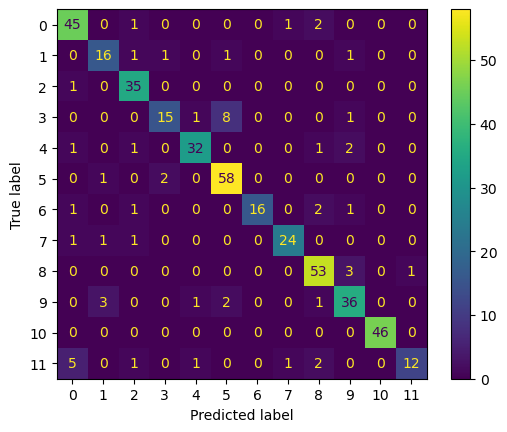

In [37]:
category_show(model_xgb, x_val, y_val)

<br>
<br>
<br>

# Predict Test Dataset

## Preprocess Images

In [ ]:
def preprocessing_test_imgs(file_dir):
    """Preprocess train image by applying equalize() and then extract_seedling().
       Store the preprocessed images in train_preprocessed folder and get their class labels."""
    
    images_list = []
    img_names = os.listdir(file_dir + "test/")
    for img_name in img_names:
        img_bgr = cv2.imread(file_dir + 'test/' + img_name)
        img_equalized = equalize(img_bgr)
        img_seedling = extract_seedling(img_equalized)
        # cv2.imwrite(cls_folder + '/' + img_name, img_seedling)

        images_list.append(img_seedling)
    return images_list

In [ ]:
# imgs_list_test = preprocessing_test_imgs(data_dir)

In [ ]:
# len(imgs_list_test)

In [ ]:
# plt.imshow(imgs_list_test[0])
# plt.show()

<br>

## SIFT + BOW
做测试的话，需要注意 bow_extractor 要沿用训练集的，而不是在测试集上重新调用 bow_init()，并且测试集也不需要提取sift特征了，因为 BOW（词袋模型）肯定是要有统一的词典才有效，主要就是要这个词典统一，如果用测试集再调用 bow_init()，词典就变了。（<a href="https://github.com/friedrichor/Plant-Seedlings-Classification" style="text-decoration:none">这段话出处</a>）

In [ ]:
# %%time

# # feature_sift_list_test = sift_feature(imgs_list_test)  # 不需要
# # bow_extractor_test = bow_init(feature_sift_list_test)  # 不需要

# feature_bow_test = bow_feature(bow_extractor, imgs_list_test)  # shape = (794, 100)

In [ ]:
# print(type(feature_bow_test), len(feature_bow_test))
# feature_bow_test.shape

In [ ]:
# feature_bow_test[np.isnan(feature_bow_test)]    # Test for nan

In [ ]:
# ## Normalize
# feature_bow_normal_test = normalize(feature_bow_test)

# ## Dimensionality Reduction
# feature_bow_pca_test = dimensionalityReduction(feature_bow_normal_test, 100)
# feature_bow_pca_test.shape

<br>

## HOG

In [ ]:
# %%time

# imgs_list_test = resize_imgs(imgs_list_test)     # Resize images

# feature_hog_test = hog_feature(imgs_list_test)   # (794, 100)

In [ ]:
# feature_hog_test[np.isnan(feature_hog_test)]   # Test for nan

In [ ]:
# ## Normalize
# feature_hog_normal_test = normalize(feature_hog_test)

# ## Dimensionality Reduction
# feature_hog_pca_test = dimensionalityReduction(feature_hog_normal_test, 100)
# feature_hog_pca_test.shape

<br>

## LBP

In [ ]:
# ## 获取 LBP 特征
# feature_lbp_test = lbp_feature(imgs_list_test)     # (794, 3, 128, 128)
# type(feature_lbp_test)

In [ ]:
# ## Reshape into 2 Dimensions
# feature_lbp_test = feature_lbp_test.reshape(feature_lbp_test.shape[0], -1)
# feature_lbp_test.shape

In [ ]:
# feature_lbp_test[np.isnan(feature_lbp_test)]   # Test for nan

# # feature_lbp_test[np.logical_not(np.isnan(feature_lbp_test))]

In [ ]:
# ## Fill nan with 0
# feature_lbp_test = fill_missing(feature_lbp_test)
# feature_lbp_test[np.isnan(feature_lbp_test)]        # Test for nan

In [ ]:
# ## Normalize
# feature_lbp_normal_test = normalize(feature_lbp_test)

# ## Dimensionality Reduction
# feature_lbp_pca_test = dimensionalityReduction(feature_lbp_normal_test, 100)
# feature_lbp_pca_test.shape

<br>

## Concatenate All Features

In [ ]:
# # 将 SIFT+BOW, HOG, LBP 三种特征矩阵拼合到一起
# features_list_test = [feature_bow_pca_test, feature_hog_pca_test, feature_lbp_pca_test]


# features_test = [[] for i in range(len(feature_bow_test))]

# for feature in features_list_test:
#     features_test = np.hstack((features_test, feature))
    
# print(features_test.shape)

# # np.save(feature_dir + 'features_test', features_test, allow_pickle=True)

<br>

## Prediction

In [ ]:
predict_test = model_xgb.predict(all_feature[4440:])

In [ ]:
# print(predict_test.shape)

# predict_test

<br>

# Submission

In [ ]:
img_names = os.listdir(data_dir + "test/")

In [ ]:
img_names

In [ ]:
plt.imshow(cv2.imread(data_dir + "test/" +os.listdir(data_dir + "test/")[0]))
plt.show()

In [ ]:
classes_dict

In [ ]:
classes_dict.keys()

In [ ]:
num_to_class_dict = dict(zip(classes_dict.values(), classes_dict.keys()))
# num_to_class_dict 

In [ ]:
predict_class = []
for pred in predict_test:
    predict_class.append(num_to_class_dict[pred])
# predict_class

<br>

## df_submission

In [ ]:
df_submission = pd.DataFrame()
df_submission['ID'] = img_names
df_submission['Category'] = predict_class

In [ ]:
df_submission.head()

In [ ]:
df_submission.to_csv("./PlantSeedlingsClassificationbyML.csv", index=False)